# Isomap

$\textbf{Motivation:}$ Isomap (isometric mapping) is a non-linear dimensionality reduction methods based on spectral theory which extends the manifold methods we studied so far by aiming to preseve the $\textit{geodesic distances}$ in the lower dimension. In non-linear manifolds, the Euclidean metric for distance holds good if and only if neighborhood structure can be approximated as linear. If neighborhood contains holes, then Euclidean distances can be highly misleading. Instead, Isomap starts by creating a neighborhood network. Then, it uses graph distance to the approximate geodesic distance between all pairs of points. If we measure the distance between two points that way, we will have a better approximation of how far or near two points are. Consider the following toy example where we have 2-D data lying on a circular manifold:

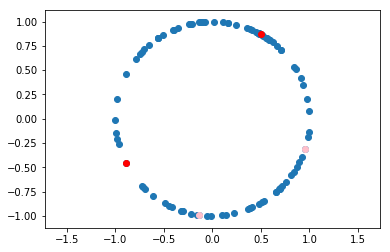

In [51]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(1,100);
y = np.sqrt(1 - np.square(x));

sign = np.random.choice([-1, 1], 100)
x = np.multiply(x,sign[0:100])
sign = np.random.choice([-1, 1], 100)

sign[5] = sign[95];
sign[35] = sign[65];

y = np.multiply(y,sign[0:100])

sort_x = np.sort(x);
nan, iloc_1  = np.where(x == sort_x[0,5])
nan, iloc_2 = np.where(x == sort_x[0,95])
nan, iloc_3 = np.where(x == sort_x[0,35])
nan, iloc_4 = np.where(x == sort_x[0,65])

iloc = [iloc_1, iloc_2, iloc_3, iloc_4];

sign_1 = np.sign(y[0,iloc[3]]);
y[0,iloc[1]] = np.absolute(y[0,iloc[1]])*sign_1;

sign_2 = np.sign(y[0,iloc[2]]);
y[0,iloc[1]] = np.absolute(y[0,iloc[1]])*sign_2;

#iloc = [1, 5, 8, 11]

plt.scatter(x,y)
plt.scatter(x[0,iloc[0]],y[0,iloc[0]],color='red')
plt.scatter(x[0,iloc[3]],y[0,iloc[3]],color='red')
plt.scatter(x[0,iloc[1]],y[0,iloc[1]],color='pink')
plt.scatter(x[0,iloc[2]],y[0,iloc[2]],color='pink')
plt.axis('equal');
plt.show()

In [52]:
y.shape

(1, 100)

The points have been sampled on a unit circle. We can select observations from the circle that are approximately on equal distiance from each other if measured as arcs on the boundary of the circle, however when embedding this inherently 1 dimensional set into 1-D line, we can see that relative distance of the points is not always well-preserved (in an intuitive way). To see that for yourself, apply with the code below the Eucledian $\textit{classical MDS}$ algorithm. 


In [53]:
import numpy as np
 
def cmdscale(D):
    """                                                                                       
    Classical multidimensional scaling (MDS)                                                  
                                                                                               
    Parameters                                                                                
    ----------                                                                                
    D : (n, n) array                                                                          
        Symmetric distance matrix.                                                            
                                                                                               
    Returns                                                                                   
    -------                                                                                   
    Y : (n, p) array                                                                          
        Configuration matrix. Each column represents a dimension. Only the                    
        p dimensions corresponding to positive eigenvalues of B are returned.                 
        Note that each dimension is only determined up to an overall sign,                    
        corresponding to a reflection.                                                        
                                                                                               
    e : (n,) array                                                                            
        Eigenvalues of B.                                                                     
                                                                                               
    """
    # Number of points                                                                        
    n = len(D)
 
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
 
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
 
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)
 
    return Y, evals

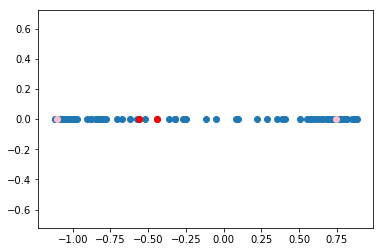

In [54]:
from scipy.spatial import distance_matrix
X = np.concatenate((x, y), axis=0)
X = np.transpose(X)
D = distance_matrix(X, X)
[XX, evals] = cmdscale(D)
plt.scatter(XX[:,0],np.zeros(100))
plt.scatter(XX[iloc[0],0],np.zeros(1),color='red')
plt.scatter(XX[iloc[1],0],np.zeros(1),color='red')
plt.scatter(XX[iloc[2],0],np.zeros(1),color='pink')
plt.scatter(XX[iloc[3],0],np.zeros(1),color='pink')
plt.axis('equal');

In almost identical scenario but schematically, suppose our data lies on a circular manifold in a 2-D structure like in the image below. We will reduce the data to 1-D using the Euclidean distances and approximate $\textit{geodesic distances}$. Now, if we look at the 1-D mapping based on the Euclidean metric, we see that for points which are far apart ($a$ and $b$) have been mapped poorly. Only the points which can be approximated to lie on a linear manifold ($c$ and $d$) give satisfactory results. On the other hand, see the mapping with geodesic distances, it nicely approximates the close points as neighbors and far away points as distant.
![title](isomap_explain.png)
<br>
The geodesic distances between two points in the image are approximated by graph distance between the two points. Isomap suggests that, Euclidean distances should not be used for approximating the distance between two points in non-linear manifolds while geodesic distances can often be useful and intuitive.

Isomap is closely related to the original multidimensional scaling algorithm proposed by the Torgerson and Gower. In fact, it is an extension of the classical multidimensional scaling. The Classical multidimensional algorithm gives a closed form solution to the dimensionality reduction problem. Classical MDS uses the Euclidean distances as the similarity metric while Isomap uses geodesic distances.

# Isomap embedding algorithm

Let us proceed with a more formal definition of the steps involved in Isomap algorithm:

1) Pass through each point $y_i \in R^D$ in the orginal data. Determine which other points will you consider as neighbors of $y_i$ according to one of two criteria. Either consider all points within radius of $\epsilon$ of $y_i$ as neightbours of $y_i$ and proceed to next point $y_{i+1}$; or denote the $K$-nearest neighbors of $y_i$ as its neighbors. Note that if we are using $K$-nearest neighbors criterion, we can sort the original data and as we are passing through each point $y_i$ we compare the Eucleadian distance of points that are around $y_i$ in the sorted array and choose the $K$ closest as neighbors.

2) Once the neighbors of each point $y_i$ have been determined, we construct a graph with $N$ nodes where two nodes are connected if they are found to be neighbours in the previous step. The edge length between two nodes is defined to be the Eucleadian distance between the two points from the data which this nodes represent. 

3) Compute the shortest path between pairs of points. This is usually done with Floyd–Warshall algorithm (or Dijkstra's algorithm). The choice of optimal shortest path algorithm will depend on the structure of the graph estimated in the previous: in sparse graphs Dijkstra's method is faster where Floyds algorithm is more efficient in denser graphs. In general however, optimal shortest path method also depends on the type of computer language and compiler. $\textit{I have attached below a short summary of the Floyd's shortest path algorithm to refresh your memory}$ 

4) Once we have estimated a matrix which encodes the distances between each pair of points according to the shortest path from the neighbor graph, we compute the lower dimensional embedding by applying classical multidimensional scaling (MDS) on this estimated distance matrix.  


$\textbf{Floyd-Warshal algorithm - basic implementation}$:

# ISOMAP in MATLAB

Since the original implementation of the seminal Isomap methods published in (Science 2000) (written by Tenenbaum, de Silva, and Langford) was in MATLAB, I am attaching it bellow because in some aspects it is easier to follow conceptually.

$\textbf{Drawbacks of Isomaps:}$ Isomap performs poorly when manifold is not well sampled and contains holes. Neighborhood graph creation is tricky and slightly wrong parameters can produce bad results.

# Simple implementaion

In [118]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.utils import check_array
from sklearn.utils.graph import graph_shortest_path
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import KernelCenterer

def Isomap_embedding(X, n_neighbors, n_components, max_iter):
    X = check_array(X, accept_sparse='csr')
        
    nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                                      algorithm='auto')
    nbrs.fit(X)
    kernel_pca = KernelPCA(n_components=n_components, kernel="precomputed", max_iter=max_iter)
        
    kng = kneighbors_graph(nbrs, n_neighbors,
                          mode='distance')

    dist_matrix_ = graph_shortest_path(kng,
                                            method='auto',
                                            directed=False)
    G = dist_matrix_ ** 2
    G *= -0.5
        
    embedding = kernel_pca.fit_transform(G)
    return embedding

$\textbf{Note:}$
Did you notice that after finding neighbors of each point we continued with kernel PCA applied to the distance matrix holding the shortest paths connecting each pair of points? This is because similarly to how classical MDS and PCA are related, metric MDS can be interpreted as kernel PCA. Essentially, this means that the geodesic distance matrix in Isomap can be viewed as a kernel matrix. The doubly centered geodesic distance matrix $K$ in Isomap is of the form
\begin{equation}
K=-\frac {1}{2}HD^{2}H
\end{equation}
where 
\begin{equation}
D^{2}:=(D_{ij})^{2} 
\end{equation}
is the elementwise square of the geodesic distance matrix $D = [D_{ij}]$, $H$ is the centering matrix, given by
\begin{equation}
H=I_{n}-\frac {1}{N}e_{N}e_{N}^{T},\quad \text{where } e_{N}=[1,\dots,1]^{T}\in \mathbb {R} ^{N}.
\end{equation}
However, the kernel matrix $K$ is not always positive semidefinite. The main idea for $\textit{kernel Isomap}$ is to make this $K$ as a Mercer kernel matrix (that is positive semidefinite) using a constant-shifting method, in order to relate it to kernel PCA such that the generalization property naturally emerges.

Kernel Isomap is a popular extension of the Isomap method which in theory suggest better robustness in many scenarios. 

In [113]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
X, labels = load_digits(return_X_y=True)

In [114]:
X.shape

(1797, 64)

In [127]:
X_transformed = Isomap_embedding(X, n_neighbors=10, n_components=2, max_iter=100)

In [128]:
X_transformed.shape

(1797, 2)

In [124]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-105.59,26.604,'0'),
  Text(34.9311,-38.4488,'1'),
  Text(35.2166,24.2072,'2'),
  Text(6.62876,77.0365,'3'),
  Text(-29.0136,-98.6805,'4'),
  Text(-15.061,-16.0002,'5'),
  Text(-78.8846,-19.6536,'6'),
  Text(79.0778,-16.3457,'7'),
  Text(46.2898,12.7904,'8'),
  Text(12.9093,57.7368,'9')])

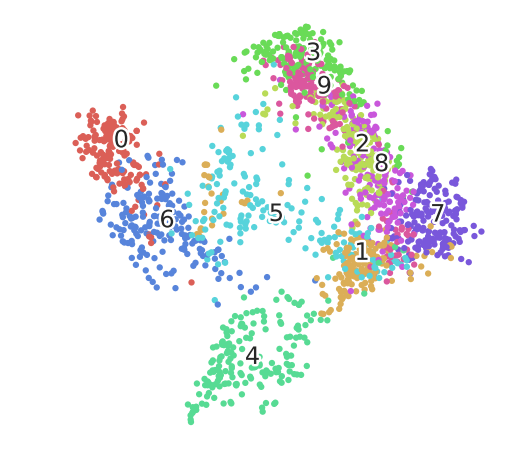

In [131]:
scatter(X_transformed,labels)

$\textbf{Embedding comparison:}$
You can add the following code in the above Isomap function if you wish to estimate the reconstruction error of the mapping which can be used as a reference of the quality of your mapping.

In [98]:
def reconstruction_error(G):
    """Compute the reconstruction error for the embedding.
    Returns
    -------
    reconstruction_error : float
    Notes
    -----
    The cost function of an isomap embedding is
    ``E = frobenius_norm[K(D) - K(D_fit)] / n_samples``
    Where D is the matrix of distances for the input data X,
    D_fit is the matrix of distances for the output embedding X_fit,
    and K is the isomap kernel:
    ``K(D) = -0.5 * (I - 1/n_samples) * D^2 * (I - 1/n_samples)``
    """
    G_center = KernelCenterer().fit_transform(G)
    evals = self.kernel_pca_.lambdas_
    return np.sqrt(np.sum(G_center ** 2) - np.sum(evals ** 2)) / G.shape[0]

$\textbf{Skicit-learn implementaion}$ which will use in some of the comparisons for compactness can be found at https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html

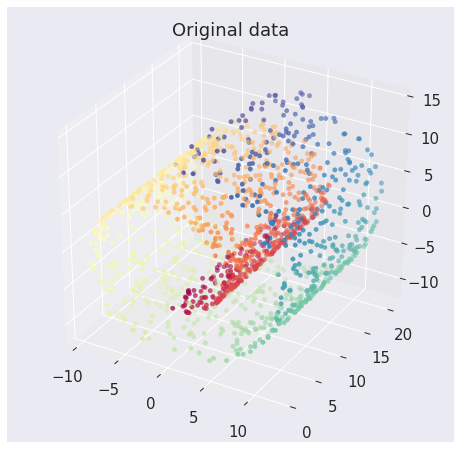

In [147]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import GPy # import GPy package
np.random.seed(12345)
# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D

#----------------------------------------------------------------------
# Locally linear embedding of the swiss roll

from sklearn import manifold, datasets
Y, labels = datasets.samples_generator.make_swiss_roll(n_samples=1500)
labels = np.round(labels)
fig = plt.figure(figsize=(8, 8))

ax = plt.subplot(projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Original data")
plt.show()

In [148]:
YY = Isomap_embedding(Y, n_neighbors=10, n_components=2, max_iter=100)

In [149]:
YY.shape

(1500, 2)

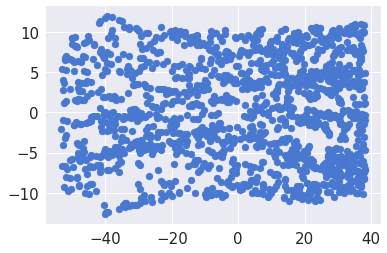

In [150]:
plt.scatter(YY[:,0],YY[:,1])

In [151]:
import matplotlib.pylab as pb
colors = ["#3FCC94", "#DD4F23", "#C6D63B", "#D44271", 
          "#E4A42C", "#4F9139", "#6DDA4C", "#85831F", 
          "#B36A29", "#CF4E4A"]
def plot_model(X, labels):
    fig = pb.figure(); ax = fig.add_subplot(111)
    #X = X[:,which_dims]
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass

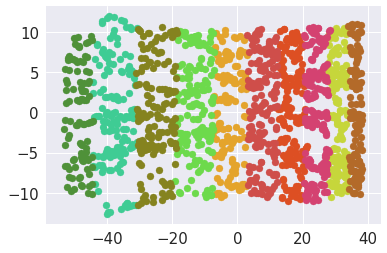

In [152]:
plot_model(YY, labels.flatten())